In [1]:
from visualisation import visualise_features, visualise_dataset
from utilities import load_dataframe, performance, cross_validation_feature_params

In [2]:
# Restart the kernel if needed
# import os
# os._exit(00)

## Exploratory Data Analysis
### Visualise our data

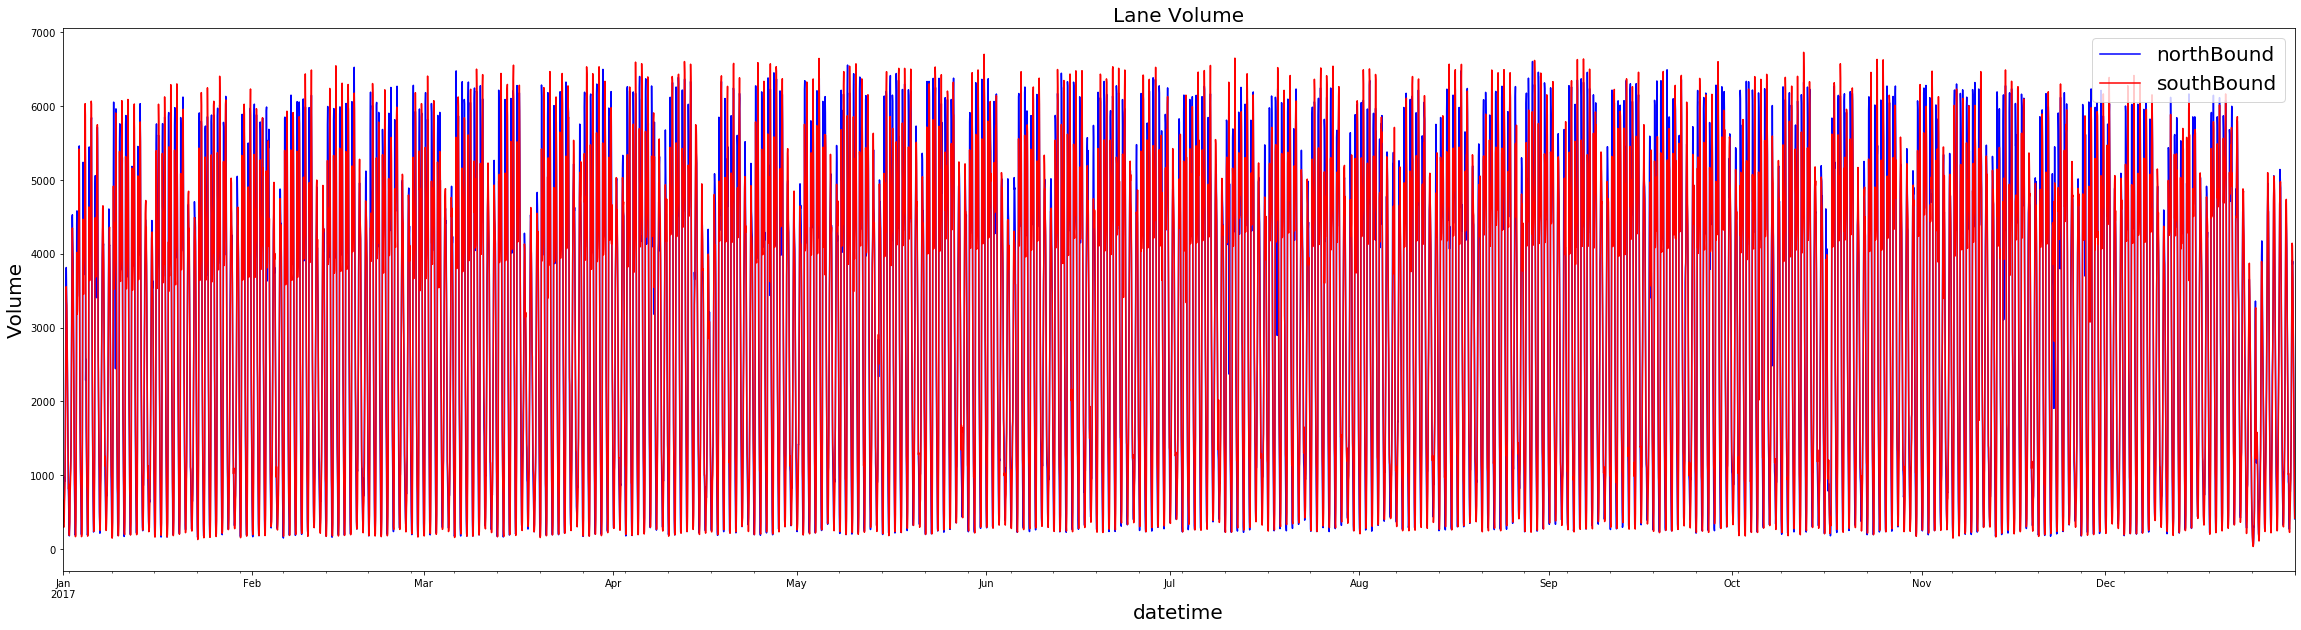

In [3]:
# Get our dataframe
df = load_dataframe()
visualise_dataset(df) # Visualised for a single year

In [4]:
df.head()

,dayOfWeek,month,time,northBound,southBound
datetime,,,,,
2014-01-01 00:00:00,3,1,0,374.0,447.0
2014-01-01 01:00:00,3,1,100,647.0,634.0
2014-01-01 02:00:00,3,1,200,420.0,489.0
2014-01-01 03:00:00,3,1,300,372.0,317.0
2014-01-01 04:00:00,3,1,400,440.0,275.0


This doesn't tell us a huge amount. Let's split the volume directions up into separate dataframes and have a closer look.

In [5]:
# Create two separate data frames, one for each junction
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

For each dataframe, let's look at a seasonality and trend plot. This could illuminate some more details to us

Base MSE for northBound traffic is: 580.0189445222752
Base MSE for southBound traffic is: 571.777911853327


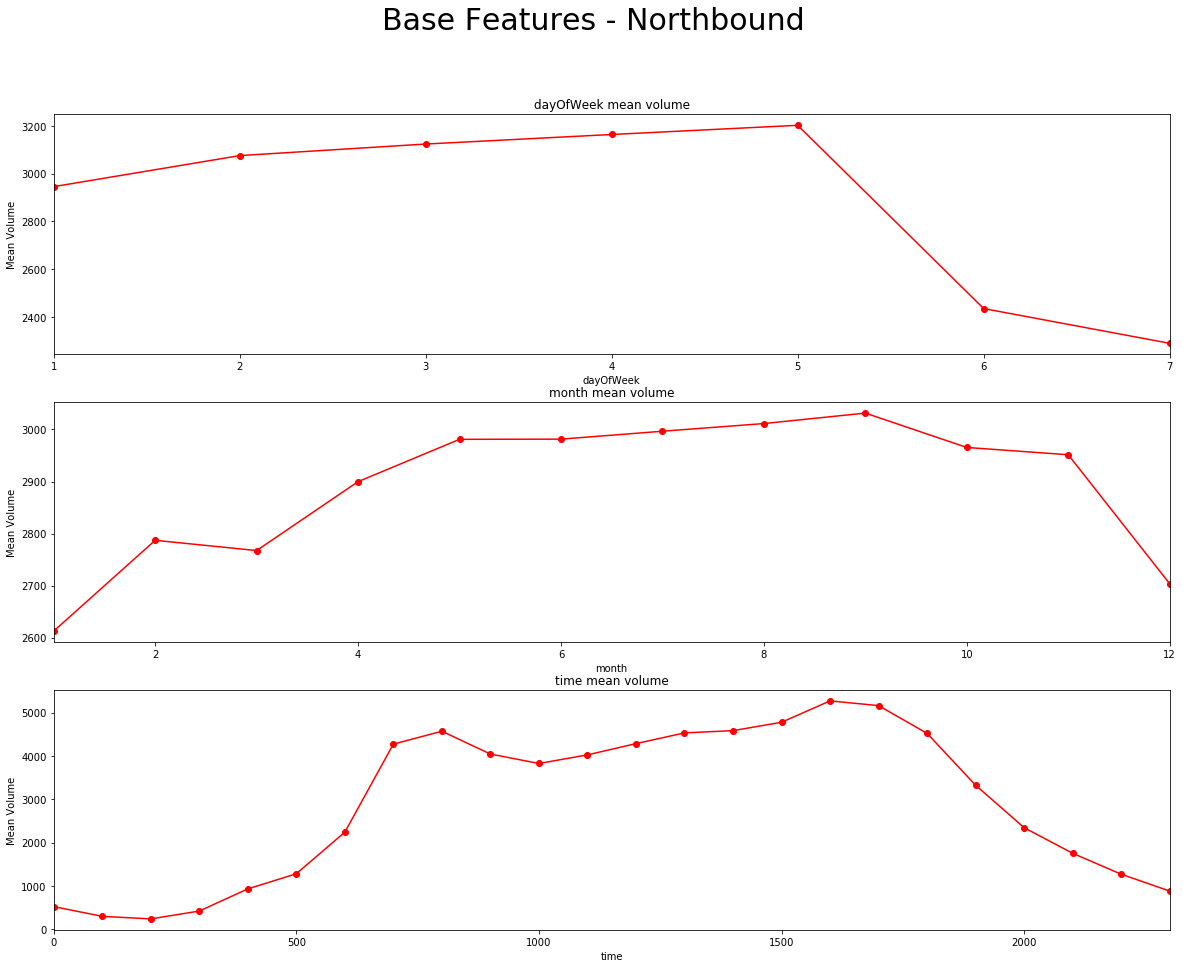

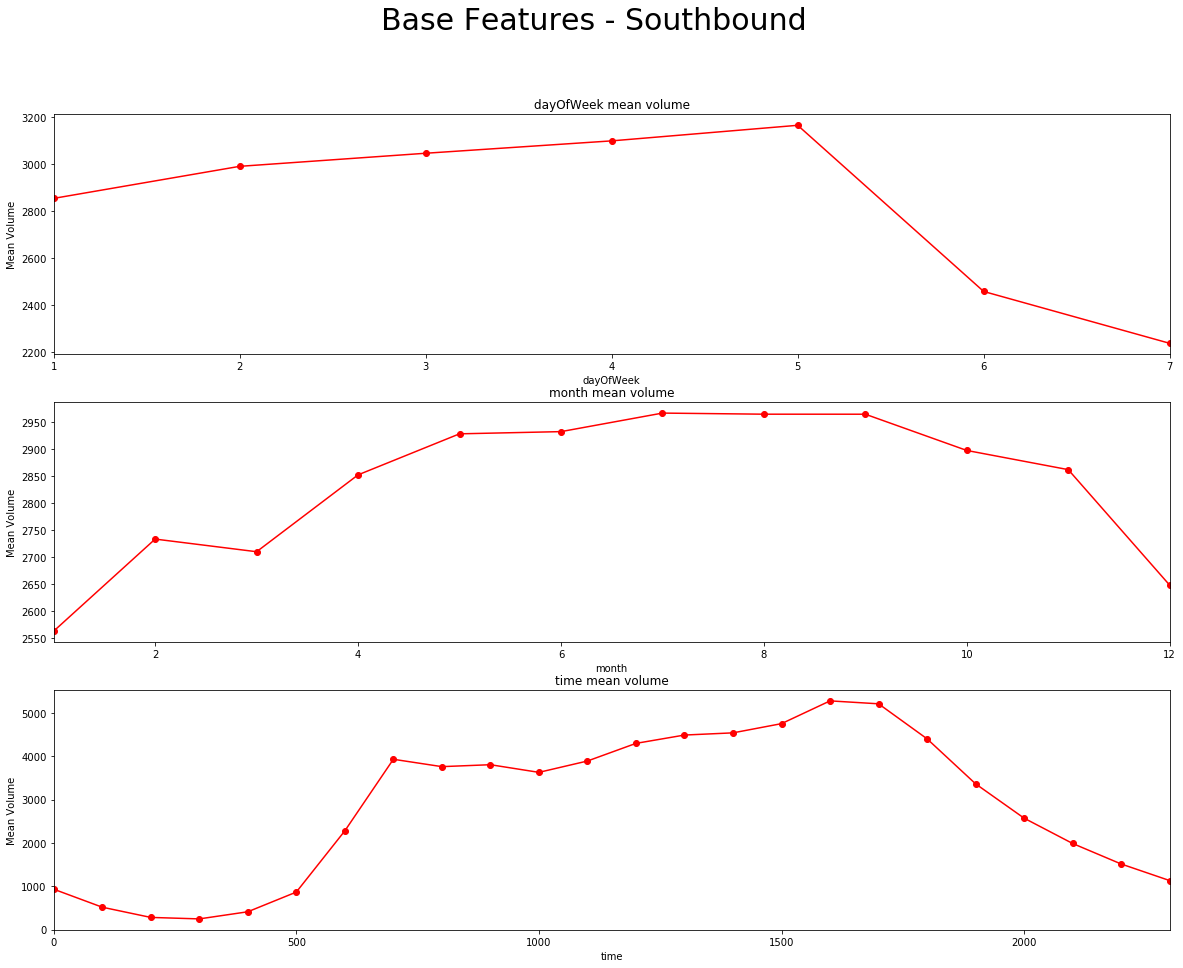

In [6]:
# Base features performance, where we use K Nearest Neighbors.
# Here is our baseline, now we add features.
performance(df_north, "northBound")
visualise_features(["dayOfWeek", "month", "time"], df_north, f"Base Features - Northbound", "northBound")

performance(df_south, "southBound")
visualise_features(["dayOfWeek", "month", "time"], df_south, f"Base Features - Southbound", "southBound")

### We see:
1. A weekly seasonality
2. A yearly seasonality
3. No overall trend throughout the year

### Extra Features

In [7]:
df_north["quarter"] = df.index.quarter
df_north["weekOfYear"] = df.index.weekofyear
df_north["dayOfYear"] = df.index.dayofyear

df_south["quarter"] = df.index.quarter
df_south["weekOfYear"] = df.index.weekofyear
df_south["dayOfYear"] = df.index.dayofyear

In [8]:
performance(df_north, "northBound")
# visualise_features(["quarter", "weekOfYear", "dayOfYear"], df_north, "Additional Features", "northBound")


performance(df_south, "southBound")
# visualise_features(["quarter", "weekOfYear", "dayOfYear"], df_south, "Additional Features", "southBound")

Base MSE for northBound traffic is: 558.4630049749949
Base MSE for southBound traffic is: 557.6665390866111


Let's try some more date-related features

In [9]:
# Get our dataframes back to original features by running cell towards top
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

import pandas as pd
ireland_holidays = {(1,1), (17,3), (5,4), (3,5), (7,6), (2,8), (25,10), (25,12), (26,12)}
# Get our dataframes back to original features
df_north = df.drop(columns=["southBound"])
df_south = df.drop(columns=["northBound"])

# Define a function to use in our mapping
def f(x):
    day = x.day
    month = x.month
    if((day,month) in ireland_holidays):
        return 1
    return 0

df_north["weekday"] = df.index.weekday
series = pd.Series(df_north.index).apply(f)
df_north["holiday"] = series.to_list()
df_north = df_north.fillna(0)

df_south["weekday"] = df.index.weekday
series = pd.Series(df_south.index).apply(f)
df_south["holiday"] = series.to_list()
df_south = df_south.fillna(0)


# Check performance
performance(df_north, "northBound")
performance(df_south, "southBound")

Base MSE for northBound traffic is: 560.8390700788472
Base MSE for southBound traffic is: 557.2266523631216


In [10]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
# Normalise
north_volumes = df_north["northBound"]
south_volumes = df_south["southBound"]

# Shape series
north_volumes = north_volumes.values.reshape(len(north_volumes), 1)
south_volumes = south_volumes.values.reshape(len(south_volumes), 1)

# train and run min-max scaler
scaler_north = MinMaxScaler(feature_range=(0,1)).fit(north_volumes)
scaler_south = MinMaxScaler(feature_range=(0,1)).fit(south_volumes)

# Normalise
normalised_north = scaler_north.transform(north_volumes)
normalised_south = scaler_south.transform(south_volumes)

# Set columns
df_north["northBound"] = normalised_north.flatten().tolist()
df_south["southBound"] = normalised_south.flatten().tolist()

In [11]:
df_north

,dayOfWeek,month,time,northBound,weekday,holiday
datetime,,,,,,
2014-01-01 00:00:00,3,1,0,0.056472,2,1
2014-01-01 01:00:00,3,1,100,0.097805,2,1
2014-01-01 02:00:00,3,1,200,0.063437,2,1
2014-01-01 03:00:00,3,1,300,0.056170,2,1
2014-01-01 04:00:00,3,1,400,0.066465,2,1
...,...,...,...,...,...,...
2018-12-31 19:00:00,1,12,1900,0.334595,0,0
2018-12-31 20:00:00,1,12,2000,0.267222,0,0
2018-12-31 21:00:00,1,12,2100,0.165178,0,0


### Review:
Looks like our base features and final two features do best.
Newer features perform quite poorly, though this could be because we have such a small dataset right now.#
However, the dayOfYear plot demonstrates some pretty significant seasonality.

## Feature Engineering
### Create lagging features
#### Need to encode components of time series data such as seasonality, trend and cycles.

/tmp/ipykernel_469728/540054940.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_469728/540054940.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


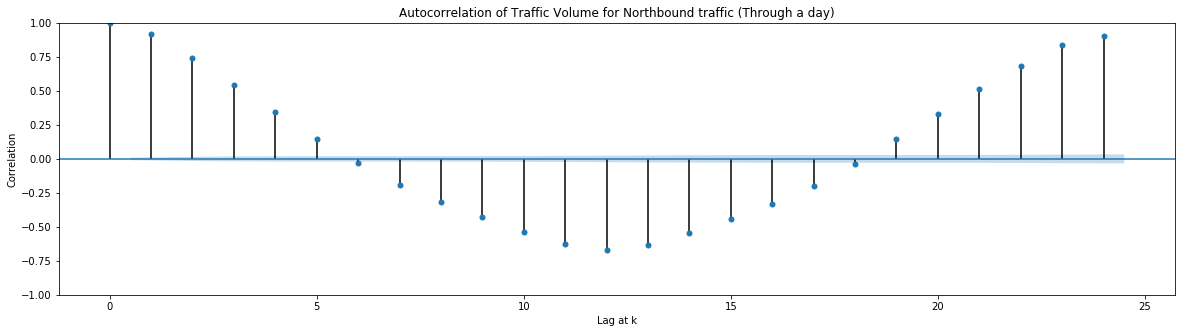

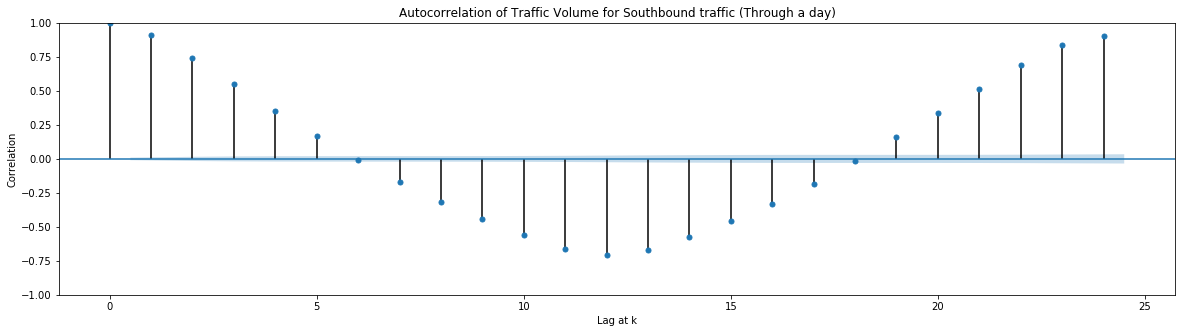

In [12]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

rcParams["figure.figsize"] = 20, 5
fig = plot_acf(df_north["northBound"], lags=24)

plt.title("Autocorrelation of Traffic Volume for Northbound traffic (Through a day)")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
fig.show()

rcParams["figure.figsize"] = 20, 5
fig = plot_acf(df_south["southBound"], lags=24)

plt.title("Autocorrelation of Traffic Volume for Southbound traffic (Through a day)")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
fig.show()

# rcParams["figure.figsize"] = 20, 5
# fig = plot_acf(df_north["northBound"], lags=24)

# plt.title("Autocorrelation of Traffic Volume for Northbound traffic (Through a day)")
# plt.ylabel("Correlation")
# plt.xlabel("Lag at k")
# fig.show()

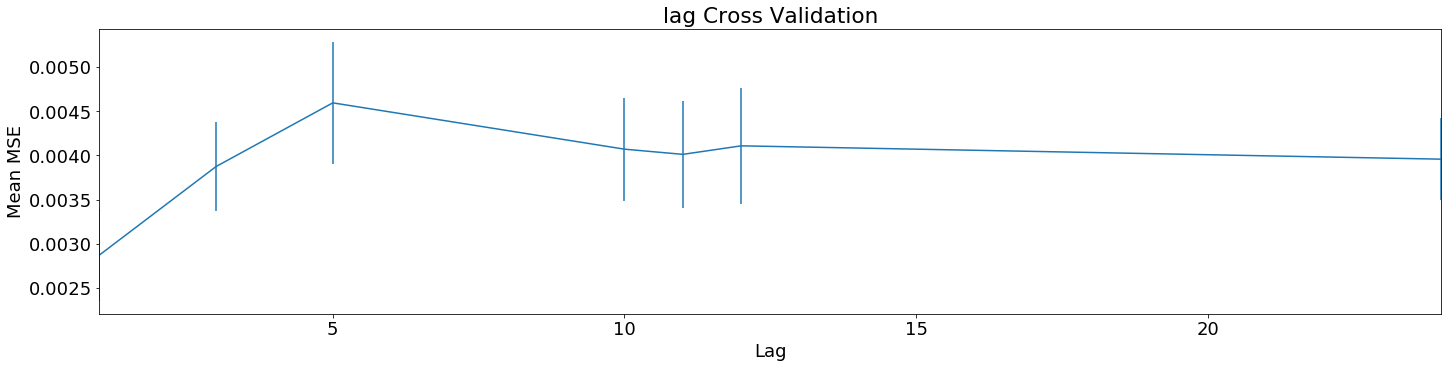

Base MSE for northBound traffic is: 0.05349739546201421
Base MSE for northBound traffic is: 0.05361705477554348
Base MSE for northBound traffic is: 0.05361653752487598
Base MSE for northBound traffic is: 0.05359655849786617
Base MSE for northBound traffic is: 0.053604692429712435
Base MSE for northBound traffic is: 0.05356353919201938
Base MSE for northBound traffic is: 0.05335886400978629
Base MSE for northBound traffic is: 0.053550965581695475
Base MSE for northBound traffic is: 0.053700146207088635


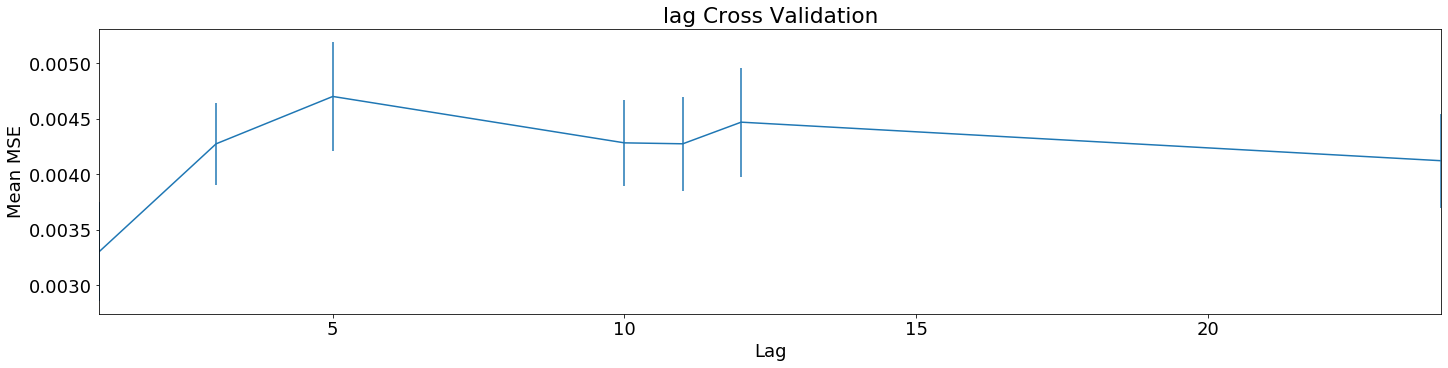

In [13]:
temp = df_north.copy()
cross_validation_feature_params(test_params=[1,3,5,10,11,12,24], df=temp, feature_type="lag", target_var="northBound")

temp_south = df_south.copy()
cross_validation_feature_params(test_params=[1,3,5,10,11,12,24], df=temp_south, feature_type="lag", target_var="southBound")

# Hour
temp["volume_lag_1"] = temp["northBound"].shift(1, fill_value=0)
performance(temp, "northBound")
temp["volume_lag_2"] = temp["northBound"].shift(2, fill_value=0)
performance(temp, "northBound")
temp["volume_lag_3"] = temp["northBound"].shift(3, fill_value=0)
performance(temp, "northBound")
temp["volume_lag_4"] = temp["northBound"].shift(4, fill_value=0)
performance(temp, "northBound")
temp["volume_lag_5"] = temp["northBound"].shift(5, fill_value=0)
performance(temp, "northBound")
temp["volume_lag_6"] = temp["northBound"].shift(6, fill_value=0)
performance(temp, "northBound")
# Difference features
temp["volume_lag_1_diff"] = temp["volume_lag_1"] - temp["northBound"].shift(2, fill_value=0)
performance(temp, "northBound")
# 12 hours
temp["volume_lag_halfday"] = temp["northBound"].shift(12, fill_value=0)
performance(temp, "northBound")
# Day
temp["volume_lag_24"] = temp["northBound"].shift(24, fill_value=0)
performance(temp, "northBound")
# # Week
# temp["volume_lag_week"] = temp["northBound"].shift(168, fill_value=0)
# performance(temp, "northBound")


Set lags, and a difference

In [ ]:


df_north["volume_lag_1"] = df_north["northBound"].shift(1, fill_value=0)
df_north["volume_lag_2"] = df_north["northBound"].shift(2, fill_value=0)
df_north["volume_lag_3"] = df_north["northBound"].shift(3, fill_value=0)
df_north["volume_lag_4"] = df_north["northBound"].shift(4, fill_value=0)
df_north["volume_lag_5"] = df_north["northBound"].shift(5, fill_value=0)
df_north["volume_lag_6"] = df_north["northBound"].shift(6, fill_value=0)
df_north["volume_lag_12"] = df_north["northBound"].shift(12, fill_value=0)
df_north["volume_lag_1_diff"] = df_north["volume_lag_1"] - df_north["northBound"].shift(2, fill_value=0)
performance(df_north, "northBound")


df_south["volume_lag_1"] = df_south["southBound"].shift(1, fill_value=0)
df_south["volume_lag_2"] = df_south["southBound"].shift(2, fill_value=0)
df_south["volume_lag_3"] = df_south["southBound"].shift(3, fill_value=0)
df_south["volume_lag_4"] = df_south["southBound"].shift(4, fill_value=0)
df_south["volume_lag_5"] = df_south["southBound"].shift(5, fill_value=0)
df_south["volume_lag_6"] = df_south["southBound"].shift(6, fill_value=0)
df_south["volume_lag_12"] = df_south["southBound"].shift(12, fill_value=0)
df_south["volume_lag_1_diff"] = df_south["volume_lag_1"] - df_south["southBound"].shift(2, fill_value=0)
performance(df_south, "southBound")

Base MSE for northBound traffic is: 247.82967635615958
Base MSE for southBound traffic is: 305.0213723848665


Interesting that the southbound performance doesnt improve to the same extent

Rolling window stuff is more or less ignored, I think we're alright with just lags for this report.

Base MSE for northBound traffic is: 191.8037382861666


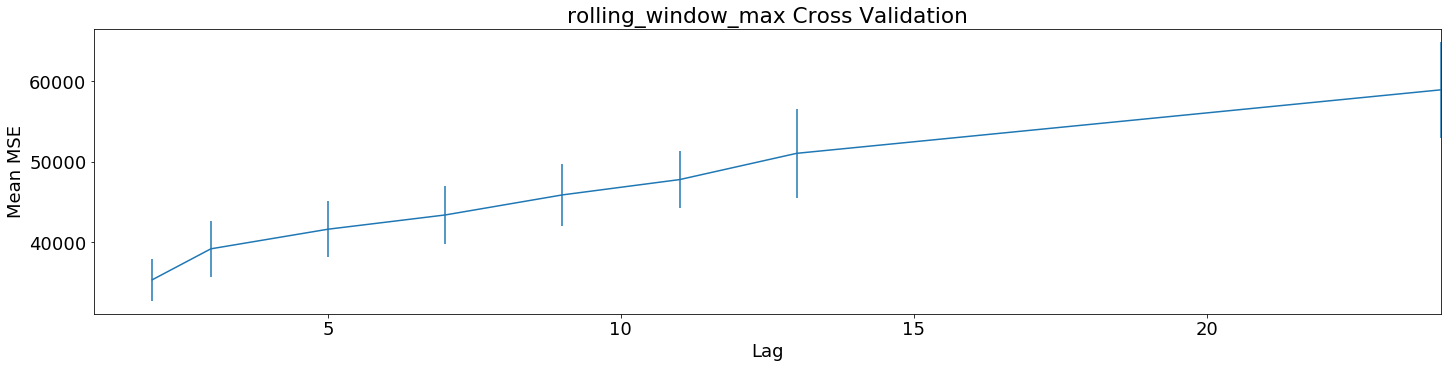

In [15]:
temp = df_north.copy()
cross_validation_feature_params(test_params=[2,3,5,7,9,11,13,24], df=temp, feature_type="rolling_window_max", target_var="northBound")
temp['window_max'] = temp['northBound'].rolling(window = 2).max()
temp['window_max'] = temp['window_max'].fillna(0)
performance(temp, "northBound")




Lower error again with the rolling window. Try mean rolling window

Base MSE for northBound traffic is: 159.17199193855447


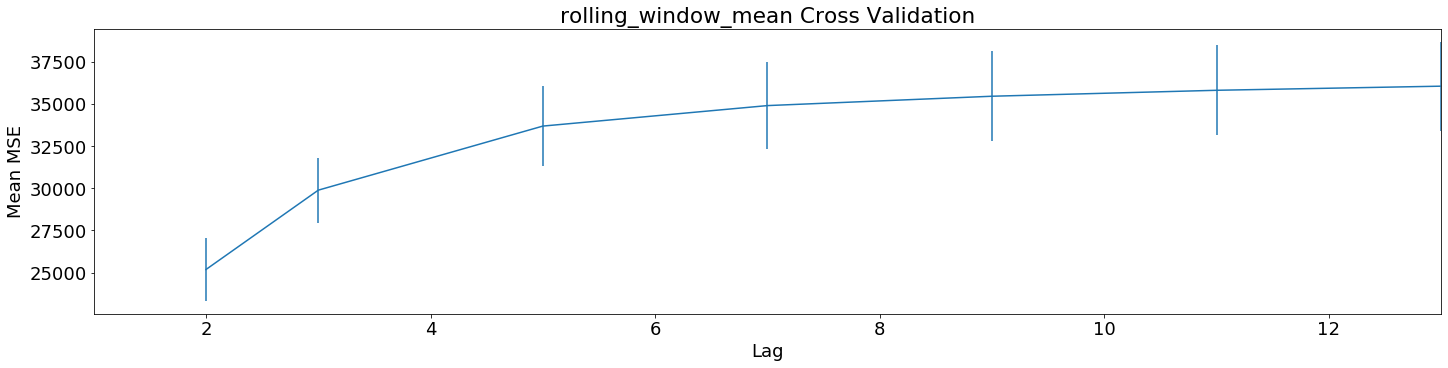

In [16]:
temp_a = df_north.copy()
cross_validation_feature_params(test_params=[2,3,5,7,9,11,13], df=temp, feature_type="rolling_window_mean", target_var="northBound")
temp['window_mean'] = temp['northBound'].rolling(window = 2).mean()
temp['window_mean'] = temp['window_mean'].fillna(0)
performance(temp, "northBound")

Much better again! See if min does any better

Base MSE for northBound traffic is: 193.1849785534564


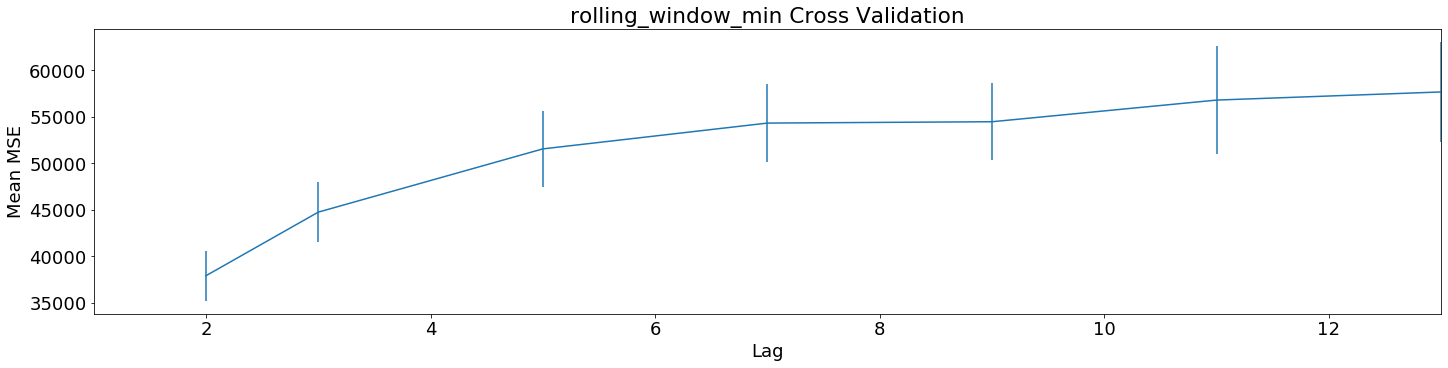

In [17]:
temp = df_north.copy()
cross_validation_feature_params(test_params=[2,3,5,7,9,11,13], df=temp, feature_type="rolling_window_min", target_var="northBound")
temp['window_min'] = temp['northBound'].rolling(window = 2).min()
temp['window_min'] = temp['window_min'].fillna(0)
performance(temp, "northBound")

In [18]:
df_north

,dayOfWeek,month,time,northBound,volume_lag_1,volume_lag_2,volume_lag_3,volume_lag_4,volume_lag_5,volume_lag_6,volume_lag_12,volume_lag_1_diff
datetime,,,,,,,,,,,,
2014-01-01 00:00:00,3,1,0,374.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 01:00:00,3,1,100,647.0,374.0,0.0,0.0,0.0,0.0,0.0,0.0,374.0
2014-01-01 02:00:00,3,1,200,420.0,647.0,374.0,0.0,0.0,0.0,0.0,0.0,273.0
2014-01-01 03:00:00,3,1,300,372.0,420.0,647.0,374.0,0.0,0.0,0.0,0.0,-227.0
2014-01-01 04:00:00,3,1,400,440.0,372.0,420.0,647.0,374.0,0.0,0.0,0.0,-48.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,1,12,1900,2211.0,2691.0,3268.0,3842.0,4033.0,4306.0,4067.0,2123.0,-577.0
2018-12-31 20:00:00,1,12,2000,1766.0,2211.0,2691.0,3268.0,3842.0,4033.0,4306.0,2357.0,-480.0
2018-12-31 21:00:00,1,12,2100,1092.0,1766.0,2211.0,2691.0,3268.0,3842.0,4033.0,2510.0,-445.0


Not quite as good.

Let's add the mean rolling window as a feature. These will be added once we've figured out how to use em for forecasting. They do a pretty nice job though.

In [19]:
# # Northbound
# df_north['window_mean'] = df_north['northBound'].rolling(window = 2).mean()
# df_north['window_mean'] = df_north['window_mean'].fillna(0)
# performance(df_north, "northBound")
# # Southbound
# df_south['window_mean'] = df_south['southBound'].rolling(window = 2).mean()
# df_south['window_mean'] = df_south['window_mean'].fillna(0)
# performance(df_south, "southBound")

We see better performance as we dont have the cross validated features also in the dataframe. 
This performance is particularly good for such a basic model!

## Model Training

We're going to try a few different models provided by sklearn. We could look beyond into things like Keras, ARIMA and XGBOOST, but I don't think it's necessary for this assignment.


Hold out a validation set. This will be used later once we've narrowed down the params for each model.

In [20]:
# We're going to hold out 12 hours of data points to predict on!~
from utilities import train_test_split
from sklearn.model_selection import TimeSeriesSplit


In [21]:

# Forecast size
n_forecast = 24*30
lag_range = 12

In [22]:


# 12-previous points
lagged_points = df_north.to_numpy()[-12-lag_range-1:-12]  # This gives us last twelve rows of training data
lagged_points = lagged_points[
    :, 3
]  # Get the volume for each row, these are our lagged points


# Target Variable
y_north = df_north["northBound"].to_numpy()
y_south = df_south["southBound"].to_numpy()

# Feature Vectors
X_north = df_north.drop(columns=["northBound"]).to_numpy()
X_south = df_south.drop(columns=["southBound"]).to_numpy()


# Hold out a validation set
(X_north, X_north_val, y_north, y_north_val) = train_test_split(X_north, y_north, test_size=n_forecast)
(X_south, X_south_val, y_south, y_south_val) = train_test_split(X_south, y_south, test_size=n_forecast)



In [23]:
# Visualise Timeseries Cross Validation
# Visualise a time-series split of 5 (80/20)
# ts_cv = TimeSeriesSplit(n_splits=5)

# fig, ax = plt.subplots(figsize=(10, 5))
# for i, (train, test) in enumerate(ts_cv.split(X_north, y_north)):
#     p1 = ax.scatter(train, [i] * len(train), c='blue', marker="_", lw=8)
#     p2 = ax.scatter(test, [i] * len(test), c='red', marker="_", lw=8)
#     ax.set(
#         title="Timeseries Split",
#         xlabel="Data point index",
#         ylabel="Cross Validation Iteration",
#         ylim=[5, -1],
#     )
#     ax.legend([p1, p2], ["Training", "Validation"])

So, let's look into Lasso and Ridge Regression first.

/users/ugrad/doylec54/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.414e+07, tolerance: 2.293e+06
  model = cd_fast.enet_coordinate_descent(
/users/ugrad/doylec54/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.919e+07, tolerance: 4.720e+06
  model = cd_fast.enet_coordinate_descent(
/users/ugrad/doylec54/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

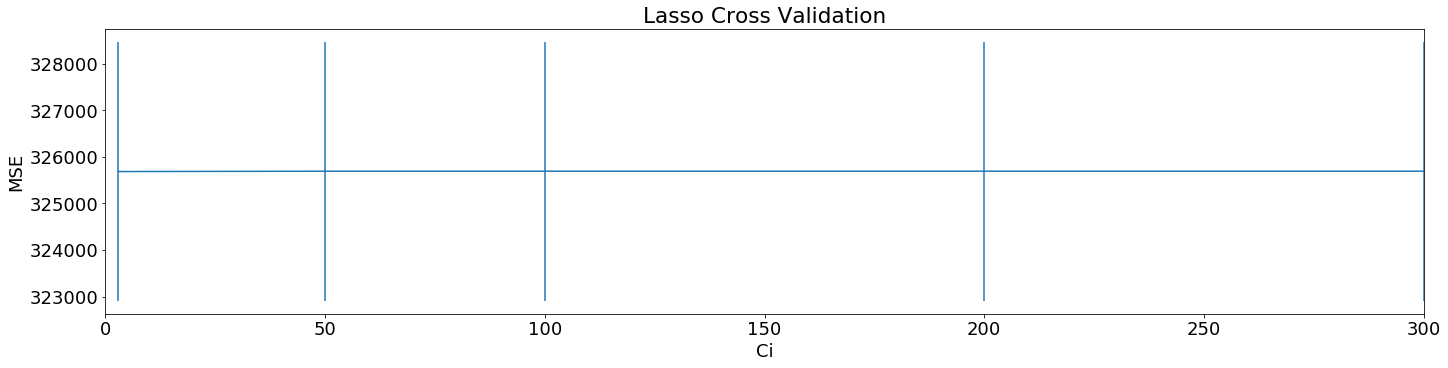

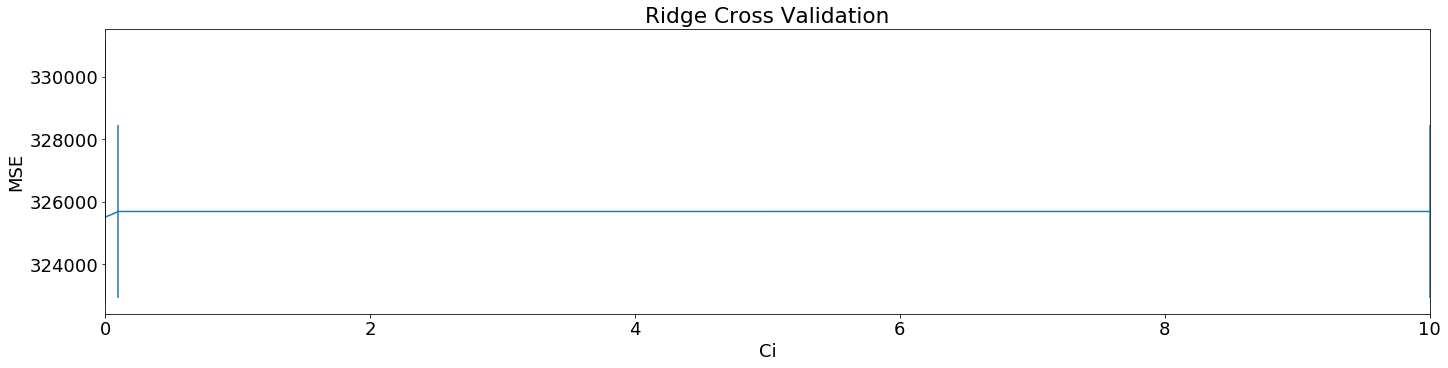

In [24]:
from models import evaluate_lasso_hyperparams, evaluate_ridge_hyperparams
evaluate_lasso_hyperparams(X_north,y_north, [3,50,100,200,300])
evaluate_ridge_hyperparams(X_north,y_north, [0.000001,0.0001,0.1,10])


Pretty awful performance lol. Not really surprising though. What is surprising is how well kNN does...

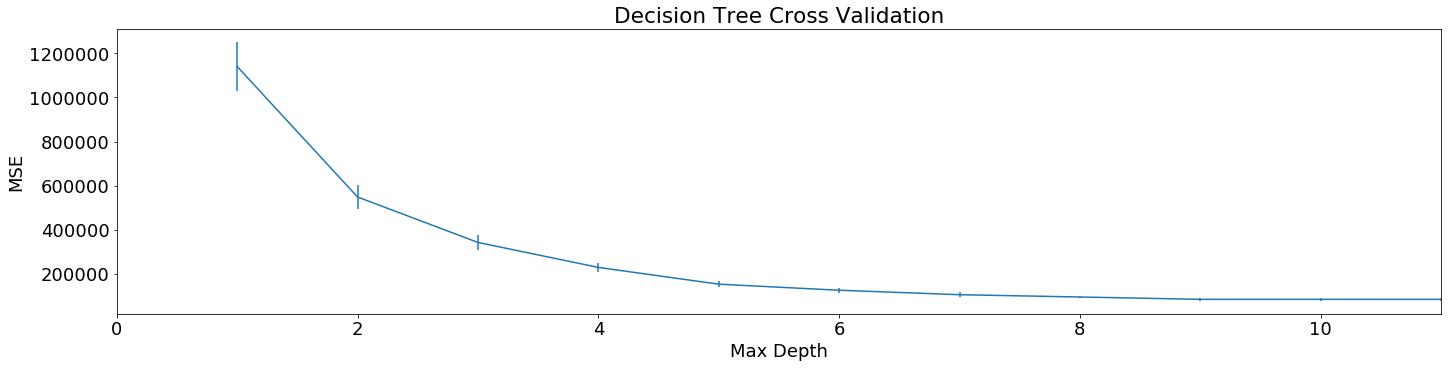

In [25]:
from models import evaluate_decision_tree_hyperparams
decision_tree_model=evaluate_decision_tree_hyperparams(X_north,y_north, [i for i in range(1,12)])

A Max Depth of 6 looks good here

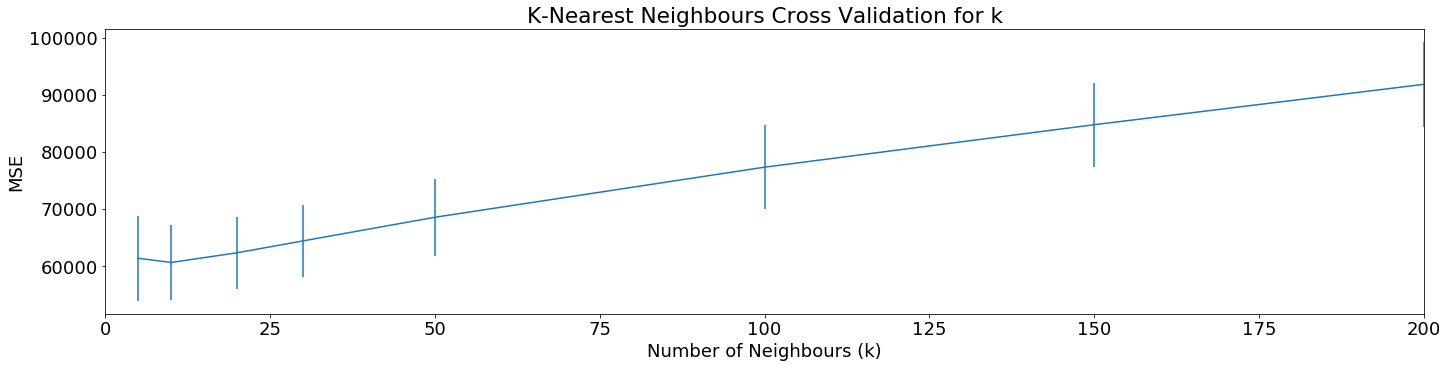

In [26]:
from models import evaluate_knn_k, evaluate_knn_k
evaluate_knn_k(X_north,y_north, [5,10,20,30,50,100,150,200])
# Not using gaussian weighting, seems to cause issues.
# 10 does best. This is interesting! Usually for large datasets, largers k's are better.
# For time series data though it makes sense!

Lets try build on our decision tree using AdaBoost
Tuning parameters takes a while so I'll leave it commented out. DONT RUN!!!

In [27]:
# # takes ages
# from sklearn.ensemble import AdaBoostRegressor

# from models import evaluate_ada_boost_hyperparams
# from utilities import get_decision_tree_models

# params_grid={
#     "base_estimator": [model for model in get_decision_tree_models(max_depth_array=range(1,20))],
#     "n_estimators":[i for i in range(5,150,5)],
#     "learning_rate":[0.01,0.1,1,1.5,2,5,10],
#     "loss":['linear', 'square', 'exponential']
# }

# evaluate_ada_boost_hyperparams(X_north,y_north,params_grid)

In [28]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# import numpy as np
ada_boost_model = AdaBoostRegressor(
     base_estimator=DecisionTreeRegressor(max_depth=16),
     n_estimators=135,
     learning_rate=1,
     loss='linear')

# ada_boost_model.fit(X_north,y_north)
# cv = TimeSeriesSplit(n_splits=5)
# scores = cross_validate(
#         ada_boost_model,
#         X_north,
#         y_north,
#         cv=cv,
#         scoring="neg_mean_squared_error",
#         return_estimator=True,
#     )

# base_mse = np.sqrt(-np.mean(scores["test_score"]))
# print(f"Ada Boost Performance MSE is: {format(base_mse)}")

# Last recoreded performance was 233.62 MSE


Bit better than the original decision tree..

Random Grid search to find the best combination of params for a random forest.
With those best params, we then test the performance. Takes a while...

In [29]:
# from models import evaluate_random_forest_hyperparams
# test_params = {
# "n_estimators": [20, 50, 60, 100],
# 'max_features': ['auto', 'sqrt', 'log2'],
# 'max_depth' : [i for i in range(5,20)]
# }
# evaluate_random_forest_hyperparams(X_north, y_north, test_params)

In [30]:
# # get a figure for the performance
# from sklearn.ensemble import RandomForestRegressor
# cv = TimeSeriesSplit(n_splits=5)
#rf_model = RandomForestRegressor(n_estimators=60, max_features="auto",max_depth=14)
# scores = cross_validate(
#         rf_model,
#         X_north,
#         y_north,
#         cv=cv,
#         scoring="neg_mean_squared_error",
#         return_estimator=True,
#     )

# base_mse = np.sqrt(-np.mean(scores["test_score"]))
# print(f"MSE is: {format(base_mse)}")

Let's get the best hyper params for an ANN. We'll plot the error bars for it since the slides do it. Takes about six minutes to run... Comment it out then run it once everything else is done.

In [31]:
# from models import evaluate_MLP_hidden_nodes, evaluate_MLP_penalty_weight
# evaluate_MLP_hidden_nodes(X_north,y_north, [5,10,15,30,50,100])
# evaluate_MLP_penalty_weight(X_north,y_north, [0.1,1,10,100,1000])

## Testing



Get a baseline performance first.
We'll use a Dummy Regressor, which predicts the mean volume for every timestamp

In [32]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
dummy_mean = DummyRegressor(strategy="mean").fit(X_north, y_north)
ydummy_mean = dummy_mean.predict(X_north_val)

print(mean_squared_error(y_north_val, ydummy_mean))

from visualisation import visualise_forecast_vs_true
x_axis = df_north.iloc[-n_forecast:].index.to_numpy()
#visualise_forecast_vs_true(x_axis, y_north_val, ydummy_mean, model_name="K-Nearest Neighbors")

3657281.0028573778


1. KNN

2600410.109503158


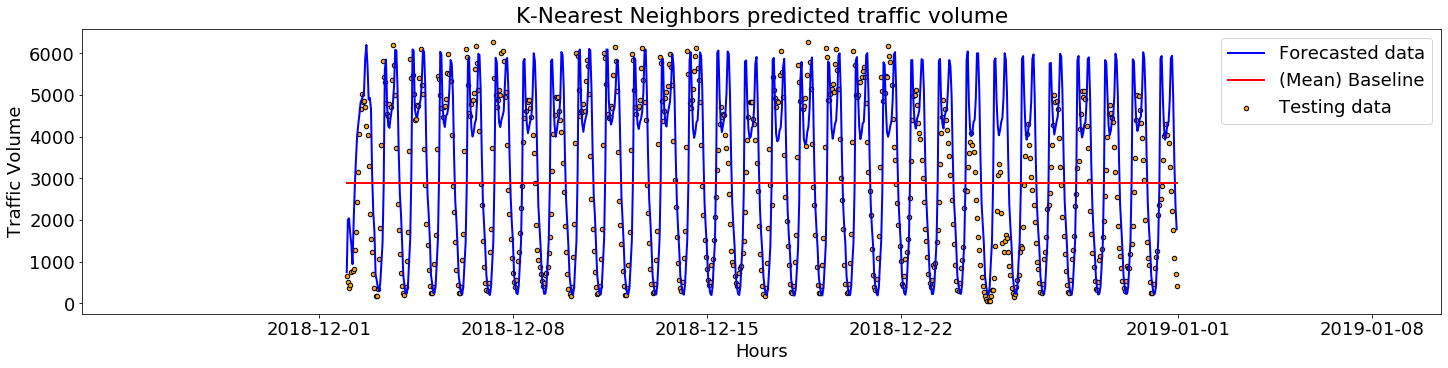

In [33]:
from sklearn.neighbors import KNeighborsRegressor
from forecasting import n_one_step_ahead_prediction

knn_model = KNeighborsRegressor(n_neighbors=10, weights="distance").fit(X_north, y_north)
y_forecast_north = n_one_step_ahead_prediction(knn_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print(mean_squared_error(y_north_val, y_forecast_north))

# Visualise
from visualisation import visualise_forecast_vs_true
x_axis = df_north.iloc[-n_forecast:].index.to_numpy()
visualise_forecast_vs_true(x_axis, y_north_val, y_forecast_north, model_name="K-Nearest Neighbors", baseline_y=ydummy_mean)

2. Decision Tree

In [34]:
from sklearn.tree import DecisionTreeRegressor
#y_forecast_north = n_one_step_ahead_prediction(decision_tree_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print("MSE: "+str(mean_squared_error(y_north_val, y_forecast_north)))
#x_axis = df.iloc[-n_forecast:].index.to_numpy()
#visualise_forecast_vs_true(x_axis,y_north_val,y_forecast_north,"Decision Tree", baseline_y=ydummy_mean)

MSE: 2600410.109503158


2. Ada Boost

MSE: 739919.9232849545


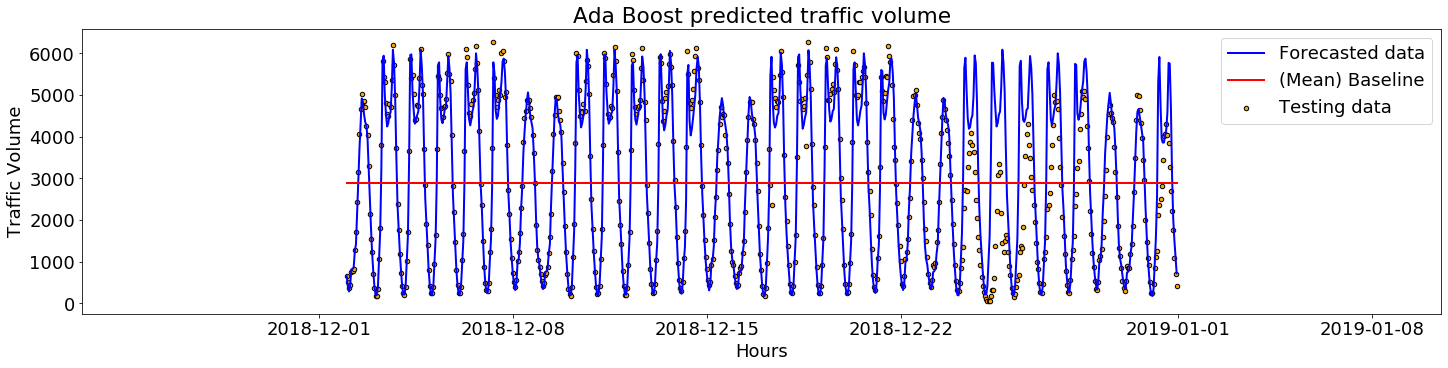

In [35]:
from sklearn.ensemble import AdaBoostRegressor
ada_boost_model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=17),
    n_estimators=40,
    learning_rate=1,
    loss='linear').fit(X_north,y_north)
y_forecast_north = n_one_step_ahead_prediction(ada_boost_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print("MSE: "+str(mean_squared_error(y_north_val, y_forecast_north)))
#x_axis = df.iloc[-n_forecast:].index.to_numpy()
visualise_forecast_vs_true(x_axis,y_north_val,y_forecast_north,"Ada Boost", baseline_y=ydummy_mean)

3. Random Forest

740564.3579048389


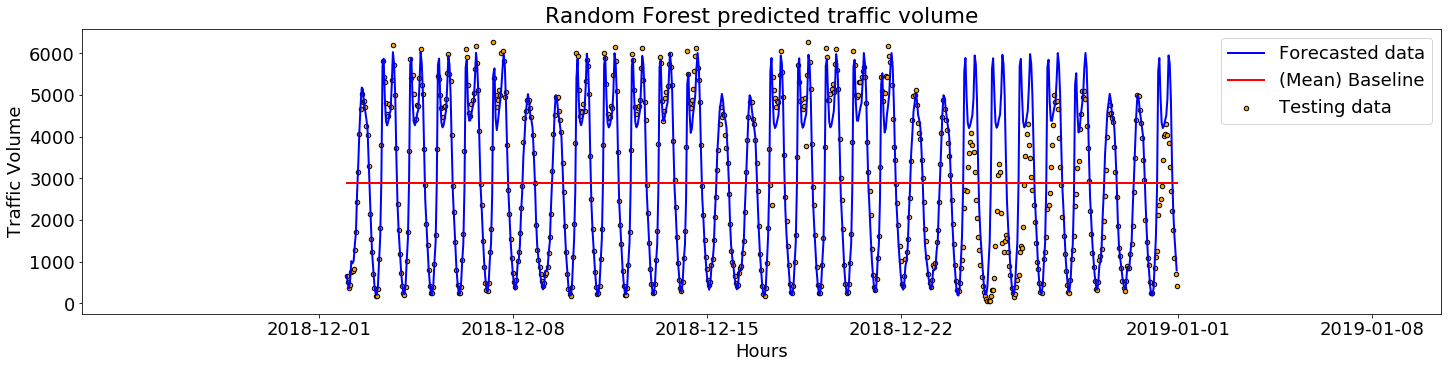

In [36]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=60, max_features="auto",max_depth=14).fit(X_north, y_north)
y_forecast_north = n_one_step_ahead_prediction(rf_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print(mean_squared_error(y_north_val, y_forecast_north))

# Visualise this
visualise_forecast_vs_true(x_axis, y_north_val, y_forecast_north, model_name="Random Forest", baseline_y=ydummy_mean)

If the results are bad, try again and it'll probably change

4. Neural Network

5662793.683609138


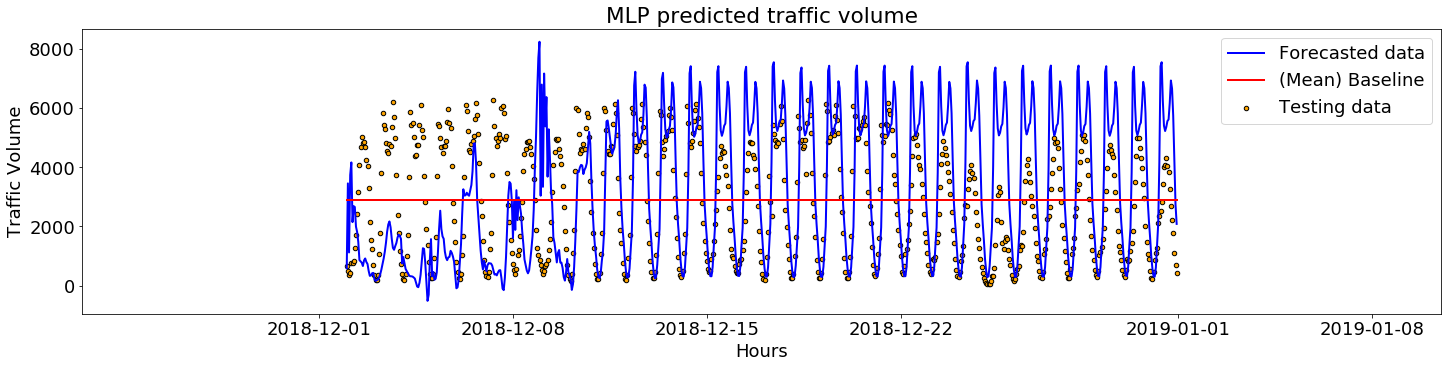

In [37]:
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=100, alpha=1000,max_iter=500).fit(X_north, y_north)
y_forecast_north = n_one_step_ahead_prediction(mlp_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print(mean_squared_error(y_north_val, y_forecast_north))
visualise_forecast_vs_true(x_axis, y_north_val, y_forecast_north, model_name="MLP", baseline_y=ydummy_mean)



5. Ridge Regression

MSE: 3376753.9332242263


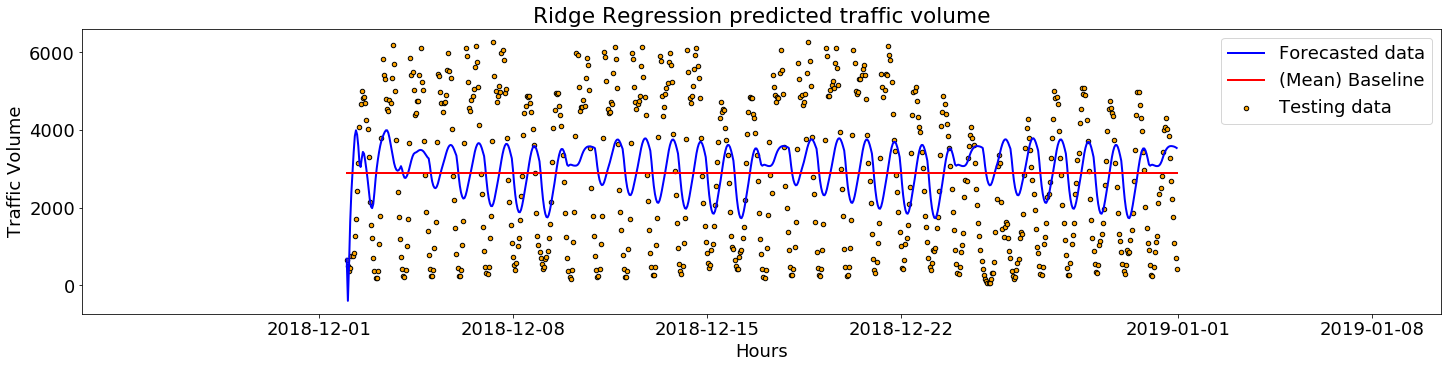

In [38]:
from sklearn.linear_model import Ridge
from forecasting import n_one_step_ahead_prediction
from visualisation import visualise_forecast_vs_true
ridge_model = Ridge(alpha=1 / (2 * 0.0001)).fit(X_north, y_north)
y_forecast_north = n_one_step_ahead_prediction(ridge_model, X_north_val, n_forecast, lagged_points, relevant_lag_indexes=[0,1,2,3,4,5,11])
print("MSE: "+str(mean_squared_error(y_north_val, y_forecast_north)))
x_axis = df.iloc[-n_forecast:].index.to_numpy()
visualise_forecast_vs_true(x_axis,y_north_val,y_forecast_north,"Ridge Regression", baseline_y=ydummy_mean)

## Discussion stuff
Lets re-train our model 12 times (for each month) so we can forecast for each month and compare the results

This is NorthBound only, needs to be done for south bound aswell

Leaving commented out for now, takes about 50 mins

In [39]:
import csv
import pandas as pd
from models import twleve_month_forecast

test_scores={}
val_month_scores={}
val_week_scores={}

(test_scores["Baseline"],val_month_scores["Baseline"],val_week_scores["Baseline"])=twleve_month_forecast(df_north,df_south,n_forecast,lag_range,"Baseline",dummy_mean)
(test_scores["Ridge Regression"],val_month_scores["Ridge Regression"],val_week_scores["Ridge Regression"])=twleve_month_forecast(df_north,df_south,n_forecast,lag_range,"Ridge Regression",ridge_model)
(test_scores["kNN"],val_month_scores["kNN"],val_week_scores["kNN"])=twleve_month_forecast(df_north,df_south,n_forecast,lag_range,"kNN",knn_model)
(test_scores["Ada Boost"],val_month_scores["Ada Boost"],val_week_scores["Ada Boost"])=twleve_month_forecast(df_north,df_south,n_forecast,lag_range,"Ada Boost",ada_boost_model)
(test_scores["Neural Network"],val_month_scores["Neural Network"],val_week_scores["Neural Network"])=twleve_month_forecast(df_north,df_south,n_forecast,lag_range,"Neural Network",mlp_model)


In [ ]:

df_test_scores=pd.DataFrame(test_scores).to_csv("model_scores/df_test_scores.csv",index=True)
df_val_month_scores=pd.DataFrame(val_month_scores).to_csv("model_scores/df_val_month_scores.csv",index=True)


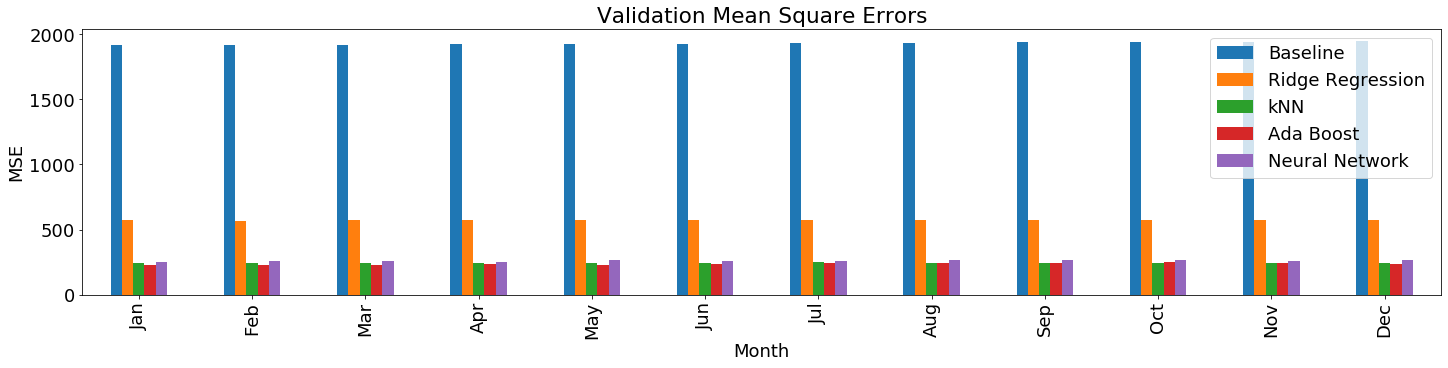

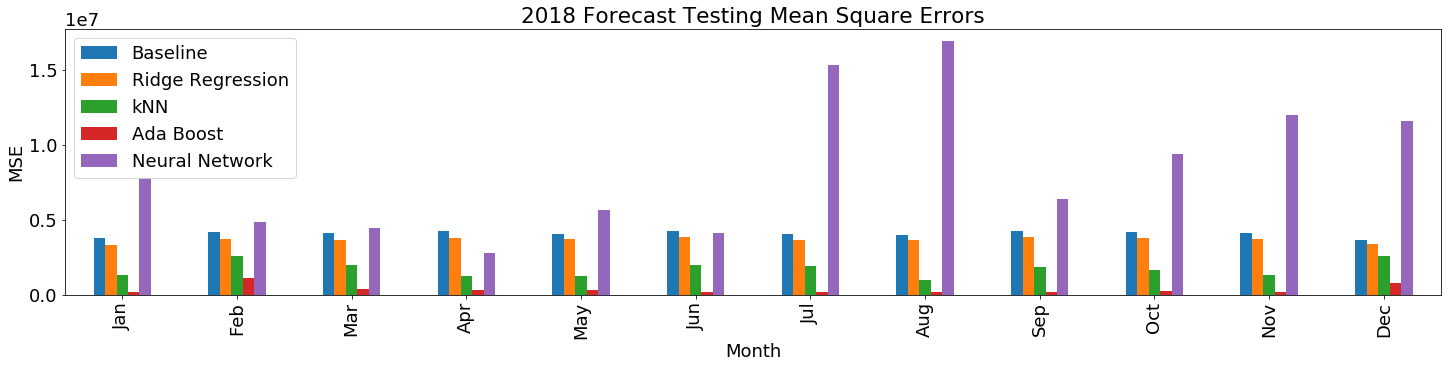

In [ ]:
from visualisation import forecast_plot

df_test_scores=pd.read_csv("model_scores/df_test_scores.csv", index_col=0)
df_val_month_scores=pd.read_csv("model_scores/df_val_month_scores.csv", index_col=0)
df_val_week_scores=pd.read_csv("model_scores/df_val_week_scores.csv", index_col=0)


#neural net MSE it so big it messes up the graph
#we'll drop it for now, need to increase the size od the graphs for visualisation
#df_val_month_scores.drop(columns=["Neural Network"],inplace=True)
#df_val_week_scores.drop(columns=["Neural Network"],inplace=True)

forecast_plot(df_test_scores,"Validation Mean Square Errors","Month",log_scale=False)
forecast_plot(df_val_month_scores,"2018 Forecast Testing Mean Square Errors","Month",log_scale=False)
#forecast_plot(df_val_week_scores,"2018 first week of each month validation MSE scores","First Week Of:",log_scale=True)


['2018-12-03T00:00:00.000000000' '2018-12-03T01:00:00.000000000'
 '2018-12-03T02:00:00.000000000' '2018-12-03T03:00:00.000000000'
 '2018-12-03T04:00:00.000000000' '2018-12-03T05:00:00.000000000'
 '2018-12-03T06:00:00.000000000' '2018-12-03T07:00:00.000000000'
 '2018-12-03T08:00:00.000000000' '2018-12-03T09:00:00.000000000'
 '2018-12-03T10:00:00.000000000' '2018-12-03T11:00:00.000000000'
 '2018-12-03T12:00:00.000000000' '2018-12-03T13:00:00.000000000'
 '2018-12-03T14:00:00.000000000' '2018-12-03T15:00:00.000000000'
 '2018-12-03T16:00:00.000000000' '2018-12-03T17:00:00.000000000'
 '2018-12-03T18:00:00.000000000' '2018-12-03T19:00:00.000000000'
 '2018-12-03T20:00:00.000000000' '2018-12-03T21:00:00.000000000'
 '2018-12-03T22:00:00.000000000' '2018-12-03T23:00:00.000000000'
 '2018-12-04T00:00:00.000000000' '2018-12-04T01:00:00.000000000'
 '2018-12-04T02:00:00.000000000' '2018-12-04T03:00:00.000000000'
 '2018-12-04T04:00:00.000000000' '2018-12-04T05:00:00.000000000'
 '2018-12-04T06:00:00.000

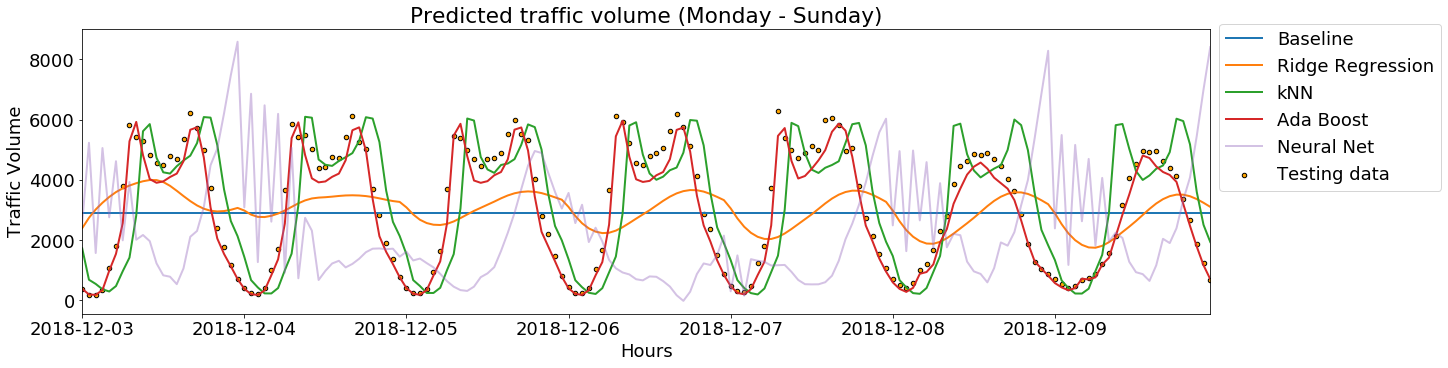

In [ ]:
from models import visualise_month_forecast,one_month_forecasting_data_prep
import numpy as np
import datetime as datetime


model_list = {"Baseline":dummy_mean,
                "Ridge Regression":ridge_model,
                "kNN":knn_model, 
                "Ada Boost":ada_boost_model,
                "Neural Net":mlp_model}

visualise_month_forecast(model_list,"Dec",df_north,df_south,n_forecast,lag_range)